Test out a log version of the best-fit curve

In [1]:
import matplotlib.pyplot as plt
from matplotlib.figure import Figure
import numpy as np
from lmfit import minimize, Parameters
import pandas as pd
#import richardsplot as rplot
from astropy.table import Table
from sklearn.preprocessing import scale
import warnings
warnings.filterwarnings('ignore')

In [2]:
! ls /Users/Trevor1/Desktop/data/files/catalogs

DR14Q_v4_4.fits                        Rankine20_CIV_HeII_wDelGI.fits
DR16Q_v4.fits                          Rankine20_CIV_HeII_wDelGI_wCIVDist.csv
DR16Q_v4.short.csv.wrelgi              dr7_bh_May09_2011.fits
Rankine20_CIV_HeII.fits


In [3]:
df = Table.read('/Users/Trevor1/Desktop/data/files/catalogs/Rankine20_CIV_HeII_wDelGI.fits', format='fits')
names = [name for name in df.colnames if len(df[name].shape) <= 1]
dat = df[names].to_pandas()
dat.head()

,SDSS_NAME,RA,Dec,z_paul,good,nBAL,AIi,BIi,CIV_blue,CIV_EW,...,FLUX_0.2_12.0keV_ERR,LUM_0.2_12.0keV,FUV,FUV_IVAR,NUV,NUV_IVAR,FIRST_FLUX,FIRST_SNR,Delta_G_I,Separation
0,b'003708.46+002855.8',9.285266,0.482174,3.02295,True,False,False,True,691.966469,75.072475,...,NaN,NaN,0.032006,45.552314,-0.018692,3.531072,-1.0,-1.0,0.600,0.000000e+00
1,b'004959.24+001903.1',12.496858,0.317540,3.32150,True,False,False,True,857.180965,32.148782,...,NaN,NaN,-0.079175,12.024832,-0.040529,3.323599,-1.0,-1.0,0.375,1.144982e-11
2,b'015017.70+002902.4',27.573786,0.484025,3.00333,True,False,False,True,1474.865400,31.916310,...,NaN,NaN,-0.068240,1074.827534,0.183702,373.859257,-1.0,-1.0,0.167,2.289918e-11
3,b'023238.49-001936.2',38.160390,-0.326749,3.34348,True,False,False,True,715.316626,40.857802,...,NaN,NaN,-0.042674,229.386872,0.313899,1.875008,-1.0,-1.0,0.831,0.000000e+00
4,b'072047.82+405455.5',110.199280,40.915418,3.04179,True,False,False,True,195.093283,106.332340,...,NaN,NaN,-0.394990,7.126986,0.070899,32.722264,-1.0,-1.0,-0.159,0.000000e+00


In [4]:
dat.shape

(145946, 61)

In [5]:
z = dat[["z_paul"]].values.flatten()
blue = dat[["CIV_blue"]].values.flatten()
EW   = dat[["CIV_EW"]].values.flatten()
logEW= np.log10(EW)
EW_HeII = dat[["HeII_EW"]].values.flatten()
D_GI = dat[["Delta_G_I"]].values.flatten()
good = dat[["good"]].values.flatten()
MI   = dat[["MI"]].values.flatten()
d    = 3.08e19 #cm
L2500= -0.4 * ( MI + 48.60 + 2.5*np.log10(1.+2) ) + np.log10(4*np.pi*(d**2))

fit = np.load("/Users/Trevor1/Desktop/data/files/CIV/RM_CIV_bestFitLine_noScale.npy") #this is the OLD linearly scaled fit

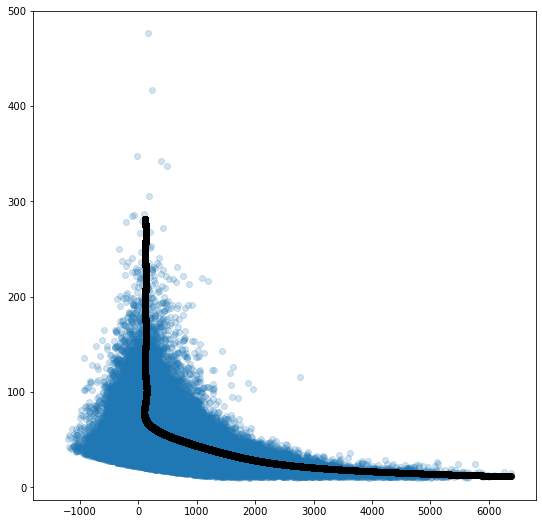

In [8]:
def f(x, coeffs):
    y = np.zeros(len(x))
    #for i in range(len(y)):
    for k in range(len(coeffs)):
        y += coeffs[k]*(x**(-k+(len(coeffs)-1)))
    return y

#Define a new "best-fit" curve now that we have Amy's data - basically piecing parts together
linex = [120] * 1000000
liney = np.linspace(300, 75, 1000000)
line1 = np.array([linex,liney]).T

linex2 = np.linspace(4000, 6400, 10000)
liney2 = [14.873] * 10000
line2  = np.array([linex2,liney2]).T
line = np.concatenate((line1, fit[((fit[:,0]>=120)&(fit[:,0]<=4000))], line2))

coeffs = np.polyfit(line[:,1], line[:,0], 16)
x = np.linspace(-3, max(EW[good]), 50018)
y = f(x, coeffs)
fit = np.array([y[((x<282)&(y<6434))], x[((x<282)&(y<6434))]-1]).T #choose what part of the curve to keep
fit = np.flip(fit, axis=0) #make x x and y y

fig = plt.figure(figsize=(9,9))
plt.scatter(blue[good], EW[good], alpha=0.2)
#plt.scatter(fit[::250,0], fit[::250,1], c="r")
#plt.scatter(line[:,0], line[:,1], c="g", label="New fit")
plt.scatter(y[((x<282)&(y<6375))], x[((x<282)&(y<6375))]-1, c="k")
plt.xlim(-1800, 6800)
#plt.ylim(-7,300)
#plt.yscale("log")
plt.show()

In [9]:
#Wrap it all in a function

def residual(coeffs, x, y):
    model = sum(coeffs[w].value*(1/(x**(-n))) for (n, w) in enumerate(coeffs))
    return (y-model)**2

def inv_powerlaw(x, y, power):
    coeffs = Parameters()
    for i in range(power+1):
        coeffs.add('W%d' % (i), value=0)
        
    return minimize(residual, coeffs, args=(x, y), method="least_squares")

def f_inv(x, coeffs):
    y = np.zeros(len(x))
    #for i in range(len(y)):
    for k in range(len(coeffs)):
        y += coeffs[k]*(x**(-k))
    return y

x_log = np.linspace(min(blue[good]), max(blue[good]), len(blue[good]))
logfit = inv_powerlaw(blue[good], logEW[good], 2)
logfit

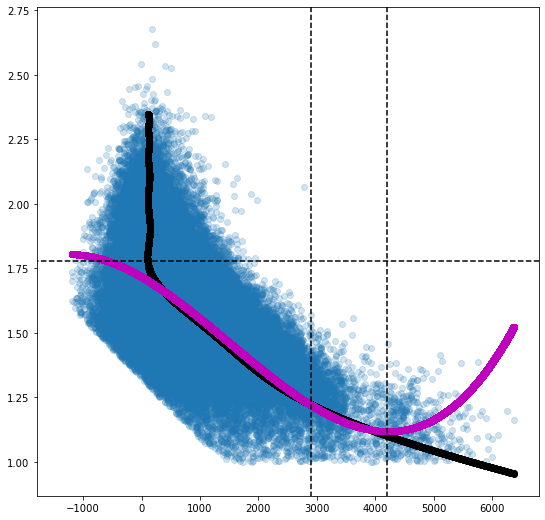

In [21]:
coeffs = np.polyfit(blue[good], logEW[good], 3)
x_log = np.linspace(min(blue[good]), max(blue[good]), len(blue[good]))
y_log = f(x_log, coeffs)

#coeffs_tilde = np.polyfit(blue[good], logEW[good], 3)

fig = plt.figure(figsize=(9,9))
plt.scatter(blue[good], logEW[good], alpha=0.2)
plt.scatter(y[((x<282)&(y<6375))]+0, np.log10(x[((x<282)&(y<6375))]-1)-.1, c="k")
plt.scatter(x_log, y_log-.03, c="m")
plt.xlim(-1800, 6800)

xlims = plt.gca().get_xlim()
ylims = plt.gca().get_ylim()

marker0 = 1.78
plt.plot([-2000,7000], [marker0,marker0], "--k")
marker1 = 2900
plt.plot([marker1,marker1], [0,3], "--k")
marker2 = 4200
plt.plot([marker2,marker2], [0,3], "--k")

plt.xlim(xlims)
plt.ylim(ylims)
#plt.ylim(-7,300)
#plt.yscale("log")
plt.show()

In [89]:
np.polyfit?

In [113]:
#Do left first to get x-coords for vertical line on top
left_mask = (fit[:,0]<marker1)&((np.log10(fit[:,1])-.1)<=marker0)
fit_left = np.array([fit[left_mask,0], np.log10(fit[left_mask,1])-.1]).T #linear-scale fit (black) leftward of the first dashed line above - rescale to log10

X = np.linspace(fit_left[0,0]-50, fit_left[0,0], 15000)
Y1 = np.linspace(2.5, marker0, 15000) 
Y2 = marker0
poly_top = np.polyfit([fit_left[0,0]-50, fit_left[0,0]], [2.5, marker0], 1)
Y = poly_top[0]*X + poly_top[1]
fit_top = np.array([X[:-1], Y[:-1]]).T #the last point is just the first point of the ``fit`` - don't want duplicates

fit_middle = np.array([x_log[((x_log>=marker1)&(x_log<marker2))], y_log[((x_log>=marker1)&(x_log<marker2))]-.03]).T #log-scale fit (magenta) between dashed lines above

xx = np.linspace(fit_middle[-1,0], 6000, 8000)
yy = -1e-6*(xx-fit_middle[-1,0]) + fit_middle[-1,1]
fit_right = np.array([xx[1:], yy[1:]]).T #the first point is just the last point of ``fit_middle`` - don't want duplicates

In [114]:
fit_top, fit_left

(array([[49.96703974,  2.5       ],
        [49.9703733 ,  2.499952  ],
        [49.97370685,  2.49990399],
        ...,
        [99.95703908,  1.78014401],
        [99.96037263,  1.78009601],
        [99.96370619,  1.780048  ]]),
 array([[9.99670397e+01, 1.77994531e+00],
        [9.99867728e+01, 1.77989038e+00],
        [1.00006590e+02, 1.77983545e+00],
        ...,
        [2.89620110e+03, 1.22257721e+00],
        [2.89795607e+03, 1.22237895e+00],
        [2.89971309e+03, 1.22218060e+00]]))

In [115]:
left_mask.sum()

5719

In [116]:
fit_top.shape, fit_left.shape, fit_middle.shape, fit_right.shape

((14999, 2), (5719, 2), (24203, 2), (7999, 2))

In [117]:
fit_middle, fit_right

(array([[2.90003828e+03, 1.22033442e+00],
        [2.90009199e+03, 1.22032695e+00],
        [2.90014570e+03, 1.22031948e+00],
        ...,
        [4.19989185e+03, 1.11843524e+00],
        [4.19994556e+03, 1.11843507e+00],
        [4.19999927e+03, 1.11843489e+00]]),
 array([[4.20022430e+03, 1.11843466e+00],
        [4.20044933e+03, 1.11843444e+00],
        [4.20067436e+03, 1.11843421e+00],
        ...,
        [5.99954994e+03, 1.11663534e+00],
        [5.99977497e+03, 1.11663511e+00],
        [6.00000000e+03, 1.11663489e+00]]))

In [118]:
new_logfit = np.concatenate((fit_top, fit_left, fit_middle, fit_right), axis=0)
new_logfit

array([[4.99670397e+01, 2.50000000e+00],
       [4.99703733e+01, 2.49995200e+00],
       [4.99737069e+01, 2.49990399e+00],
       ...,
       [5.99954994e+03, 1.11663534e+00],
       [5.99977497e+03, 1.11663511e+00],
       [6.00000000e+03, 1.11663489e+00]])

In [119]:
N = 0
for i in range(len(new_logfit)-1):
    if new_logfit[i,1] < new_logfit[i+1,1]: print(new_logfit[i,0], new_logfit[i,1])#N+=1
        
print(N)

0


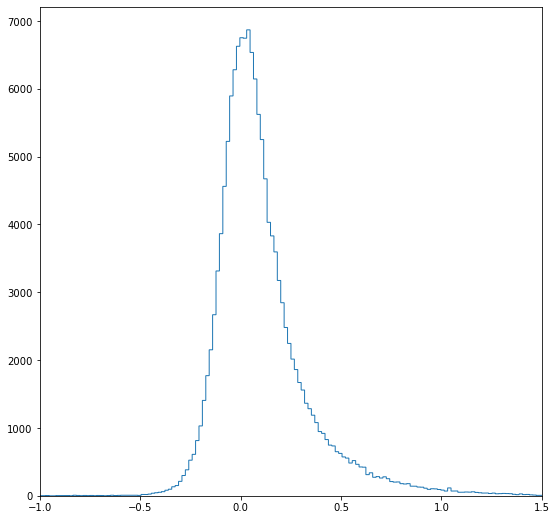

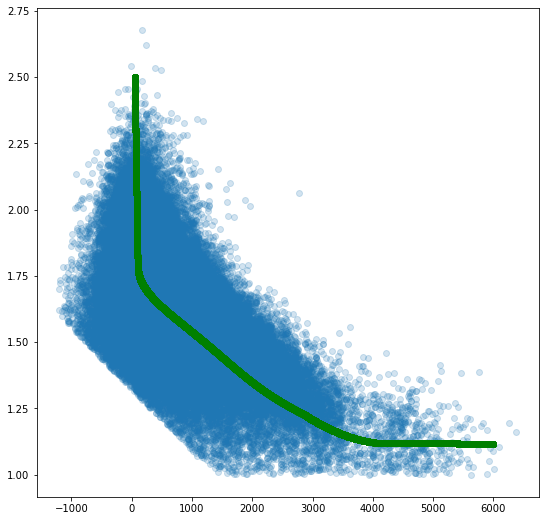

In [120]:
fig = plt.figure(figsize=(9,9))
plt.hist(D_GI, histtype="step", bins="scott")
plt.xlim(-1,1.5)
plt.show()

#Now plot the new log-scale curve
fig = plt.figure(figsize=(9,9))
plt.scatter(blue[good], logEW[good], alpha=0.2)
#plt.scatter(fit[::250,0], fit[::250,1], c="r")
plt.scatter(new_logfit[:,0], new_logfit[:,1], color="g")
#plt.xlim(-1800, 6500)
#plt.ylim(-7,390)
plt.show()

In [121]:
!ls ../CIV_Distance/data

LOFAR_from8403colorselected_all388_CIV.csv
LOFAR_from8403colorselected_detections123_1arcsec.csv
RM_CIV_bestFitLine_noScale.npy
bestfit_linear.npy
bestfit_log.npy


In [122]:
np.save("../CIV_Distance/data/bestfit.npy", new_logfit)